# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm


from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns

import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords #importing stop words
import warnings
warnings.filterwarnings('ignore')


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline


from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/josuevazquez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

Check for missing values and duplicate.

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews[df_reviews["average_rating"].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [8]:
df_reviews = df_reviews[~df_reviews["average_rating"].isna()] #Delete NaN since there are only 2 = data[~data["average_rating"].isna()] #Delete NaN since there are only 2

In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

In [10]:
df_reviews.isna().sum() #No more NaN values.

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [11]:
df_reviews.duplicated().sum() #We have no duplicates

0

Let's Normalize and clean the reviews text data and save into a new csv file so we only have to do this once. 

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [12]:
print(stopwords.words('english')) #Below are a list of all stop words that we want removed from our text

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
# Preprocessing steps
df_reviews['review'] = df_reviews['review'].apply(lambda x: x.lower()) # convert text to lowercase
df_reviews['review'] = df_reviews['review'].str.replace('[^\w\s]','') # remove punctuation
df_reviews['review'] = df_reviews['review'].str.replace('\d+', '') # remove numbers
df_reviews['review'] = df_reviews['review'].str.strip() # remove white spaces


In [14]:
df_reviews['review'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um  a serious film about troubled teens in sin...
4    im totally agree with garryjohal from singapor...
Name: review, dtype: object

In [15]:
df_reviews['review'].tail()

47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought id say this about a biopic but...
47329    spirit and chaos is an artistic biopic of miya...
47330    ill make this brief this was a joy to watch it...
Name: review, dtype: object

## EDA

Let's check the number of movies and reviews over years.

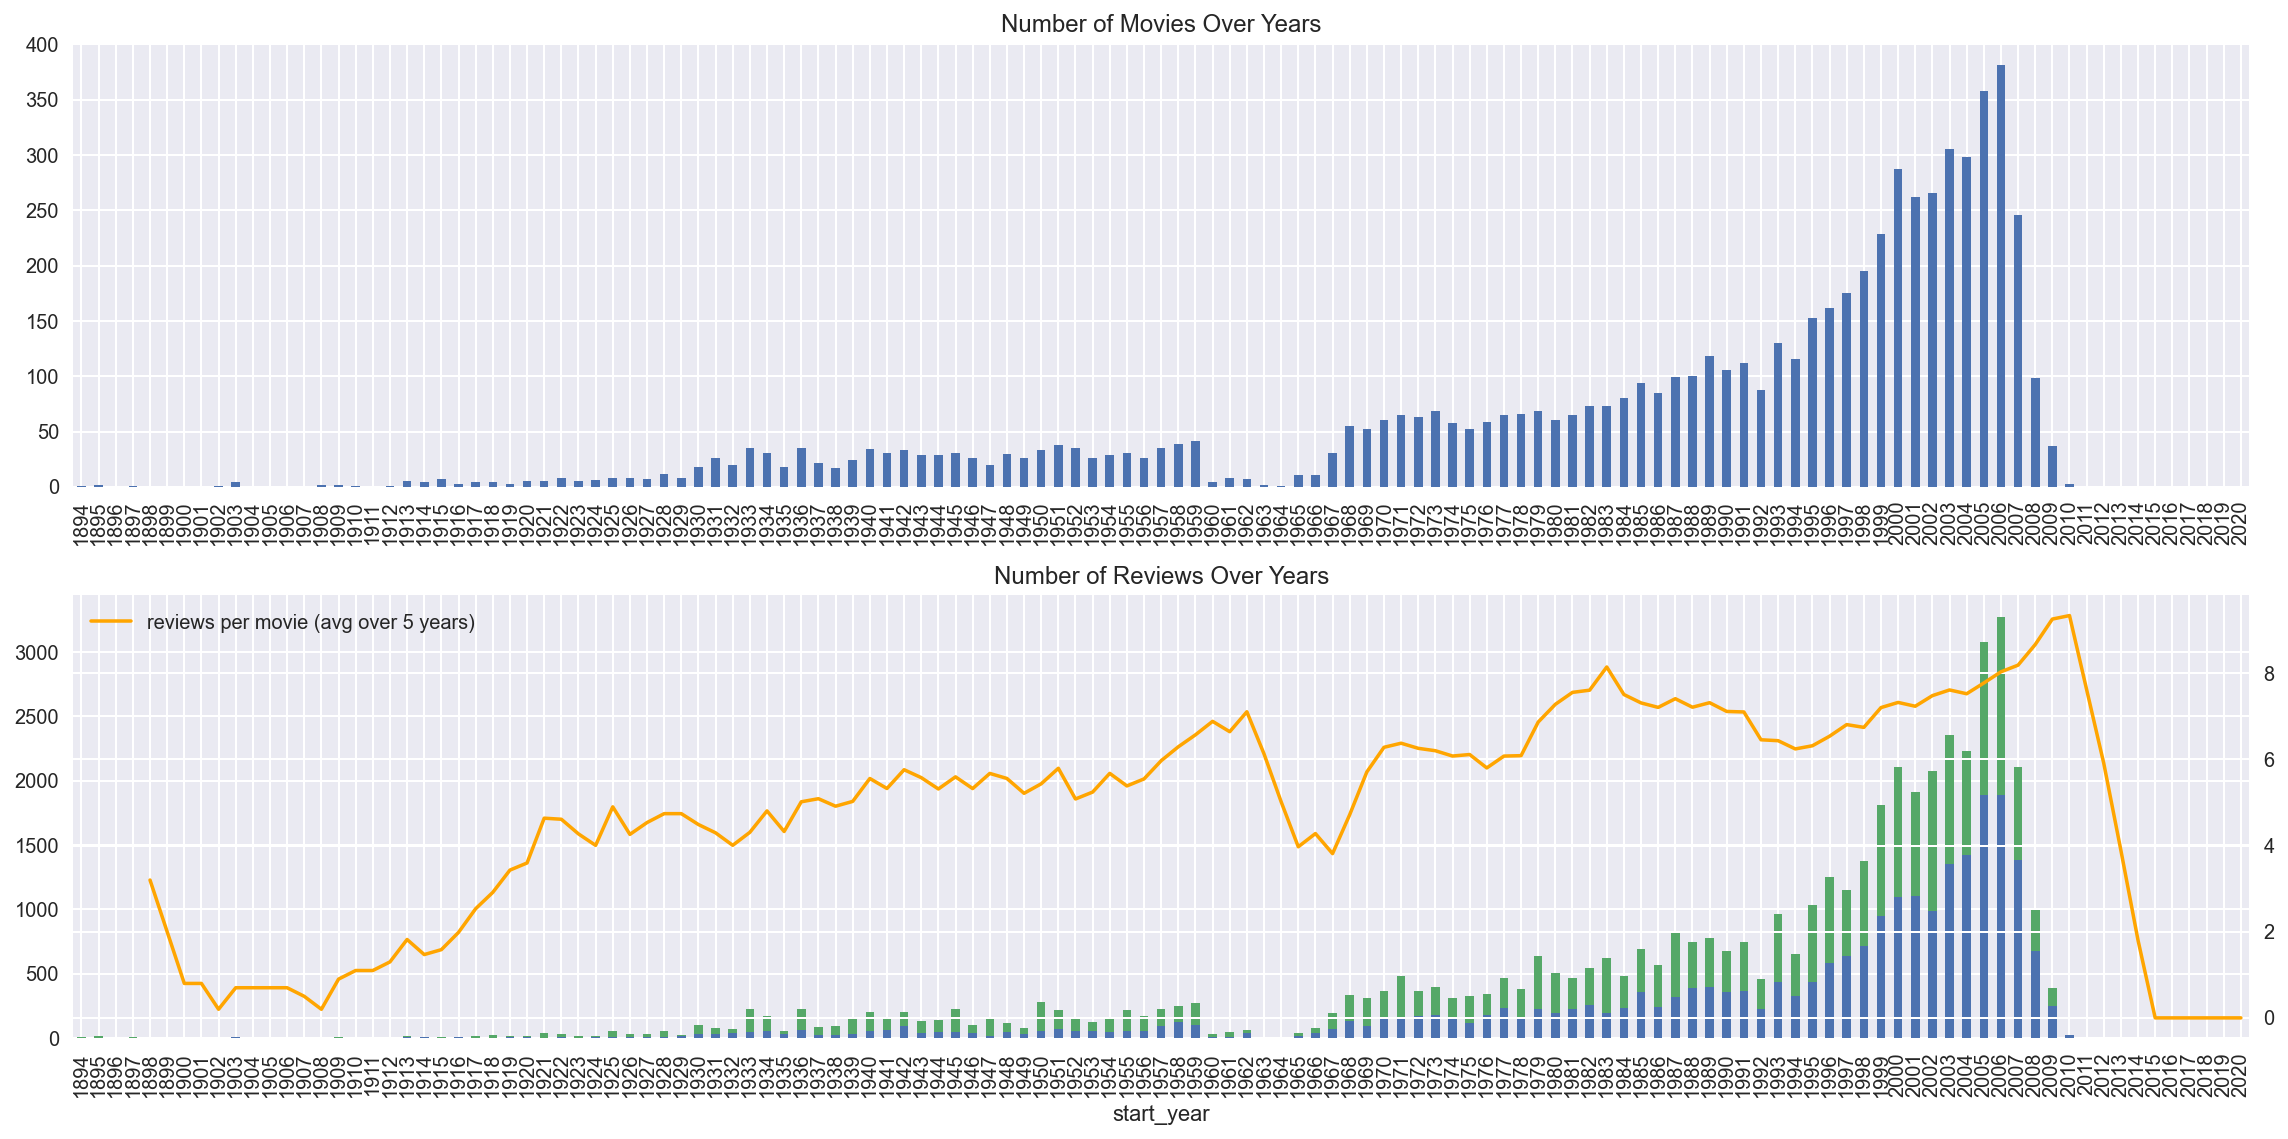

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

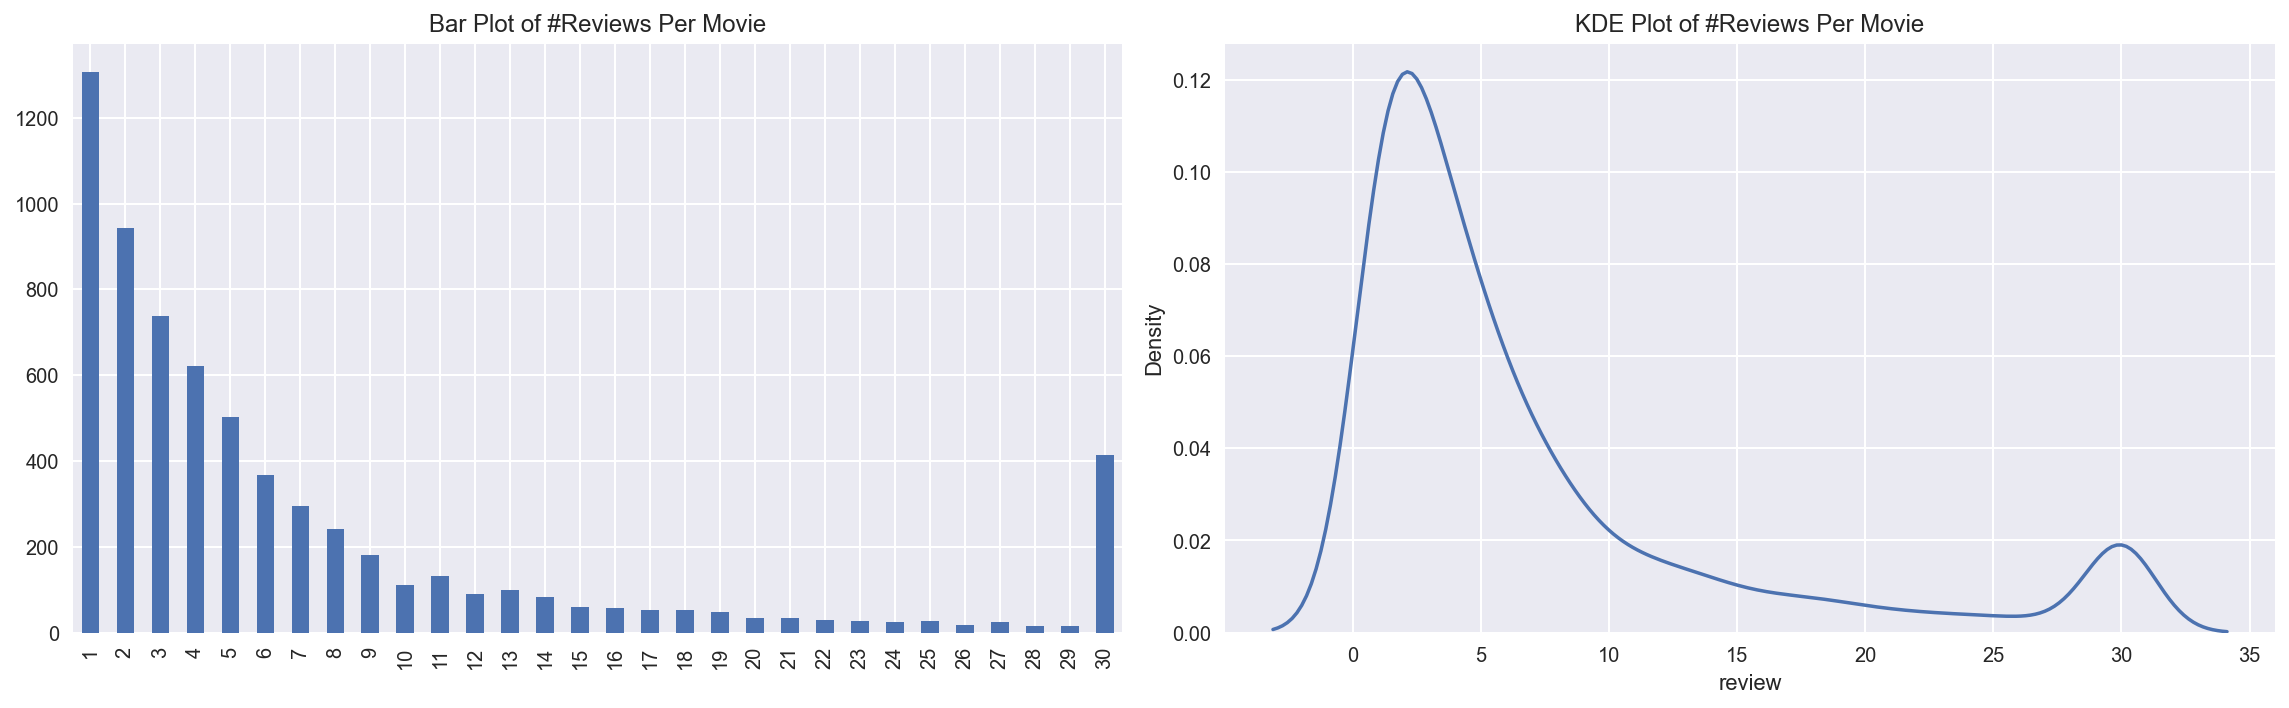

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [18]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

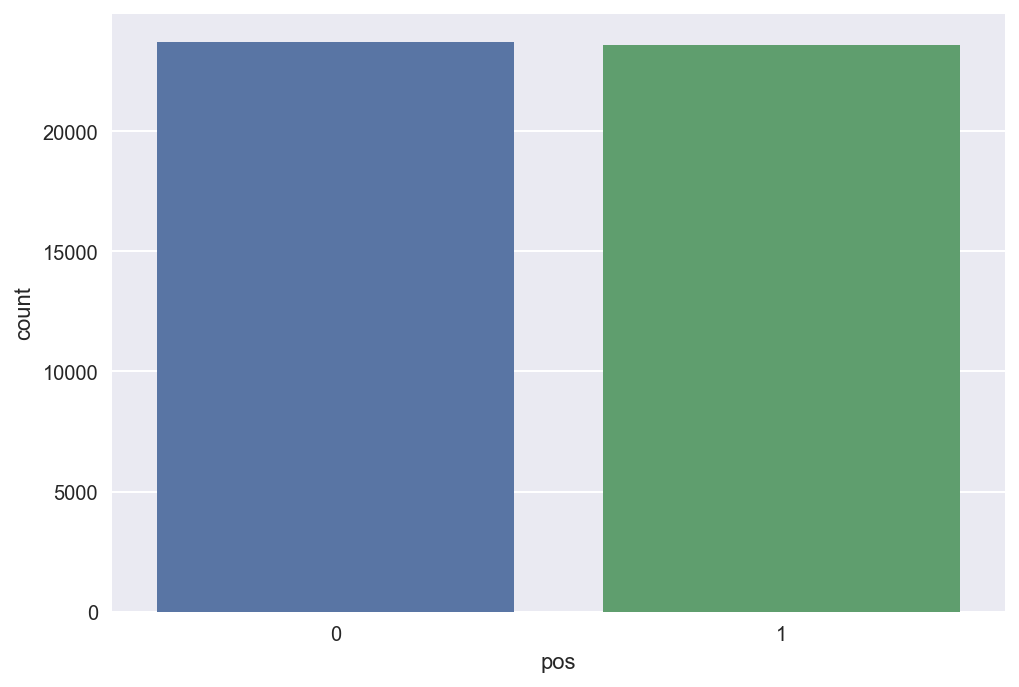

In [19]:
sns.countplot(df_reviews["pos"]); #target data is balanced and binary

We can see that we have a balanced binary target.

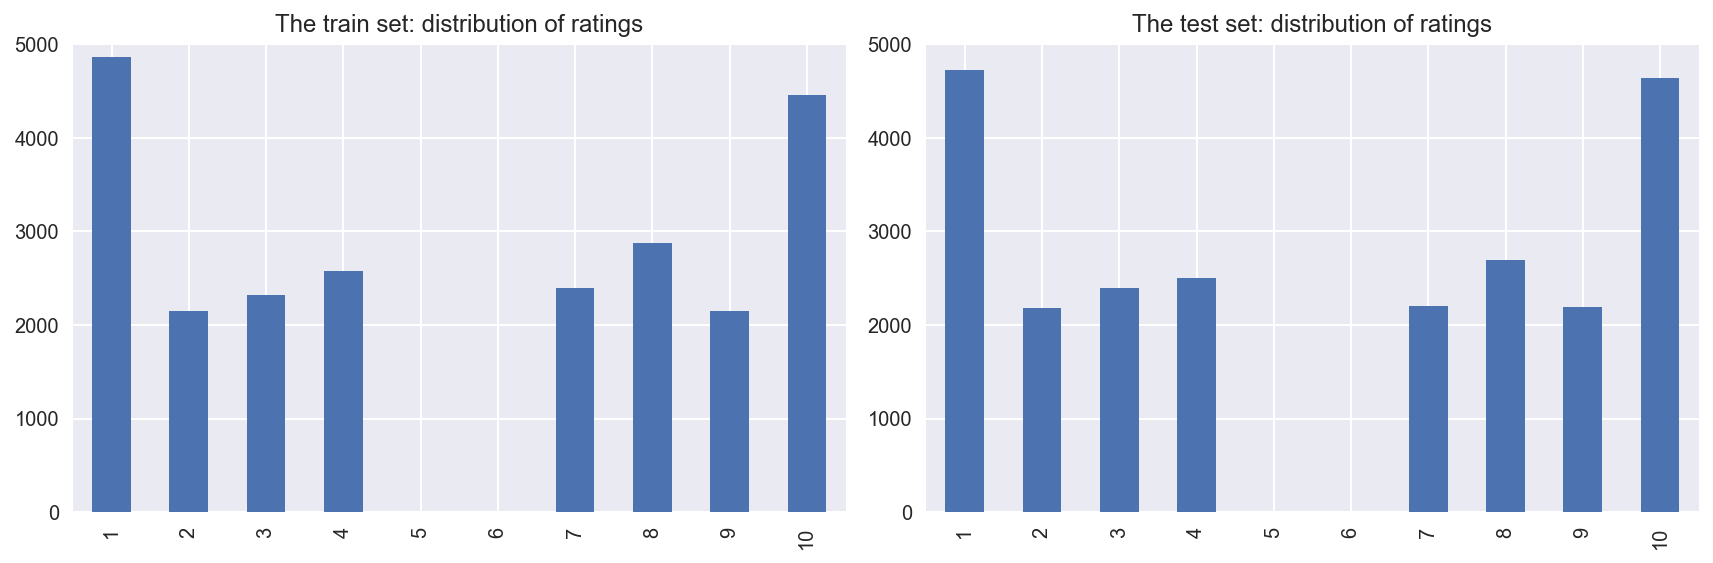

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

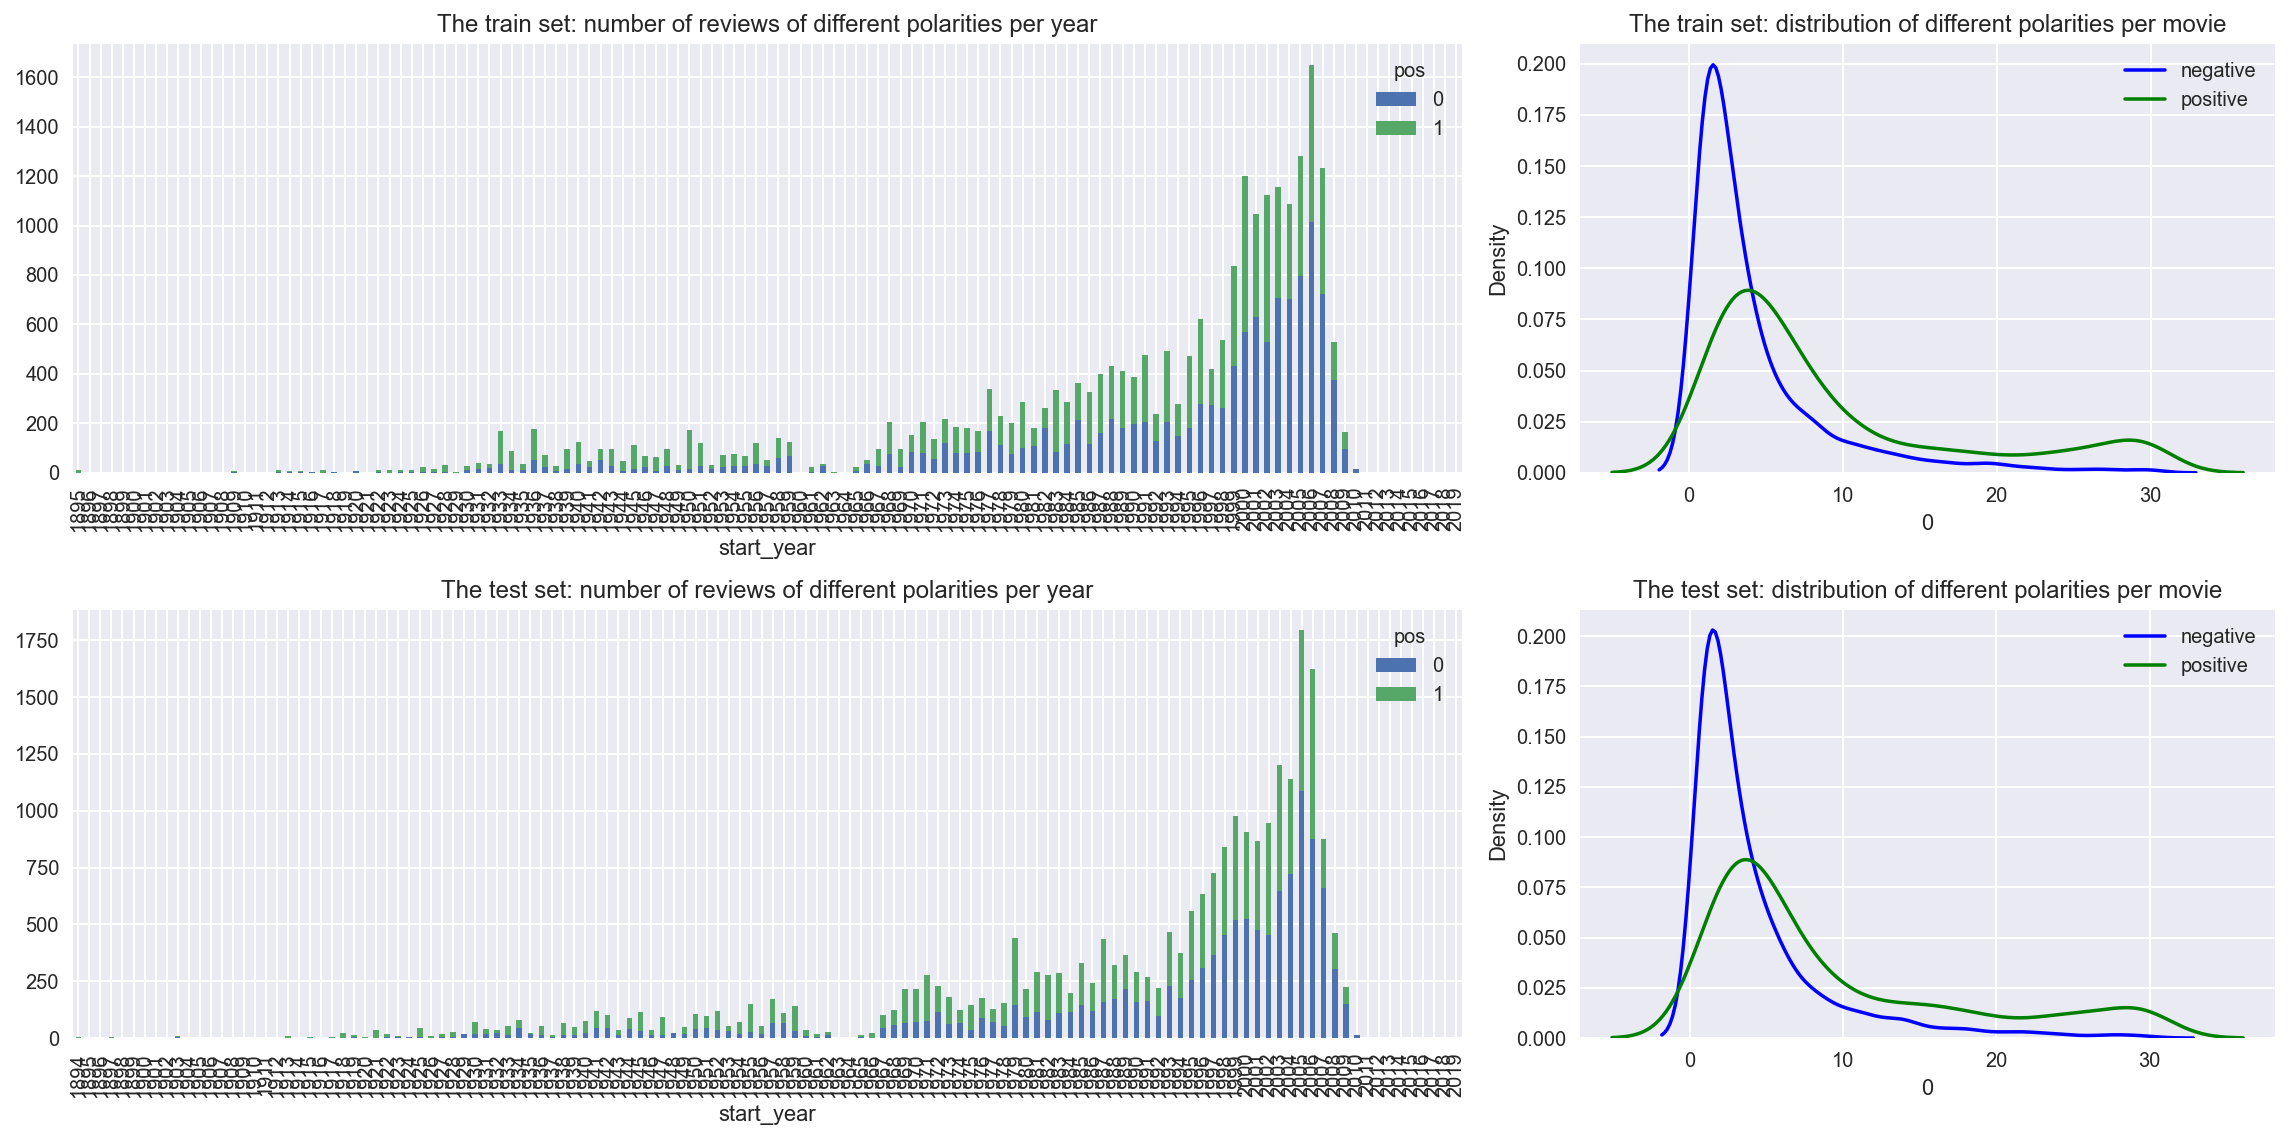

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [22]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [23]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 17)
(23533, 17)


In [24]:
target = "pos"
features = list(set(df_reviews_train.columns)-set([target]))

In [25]:
X_train, X_test, y_train, y_test =  df_reviews_train[features], df_reviews_test[features], train_target, test_target

In [26]:
y_train.shape

(23796,)

## Working with models

### Model 0 - Constant

In [27]:
from sklearn.dummy import DummyClassifier

In [28]:
model = DummyClassifier().fit(X_train, y_train)
y_pred = model.predict(X_test)



          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


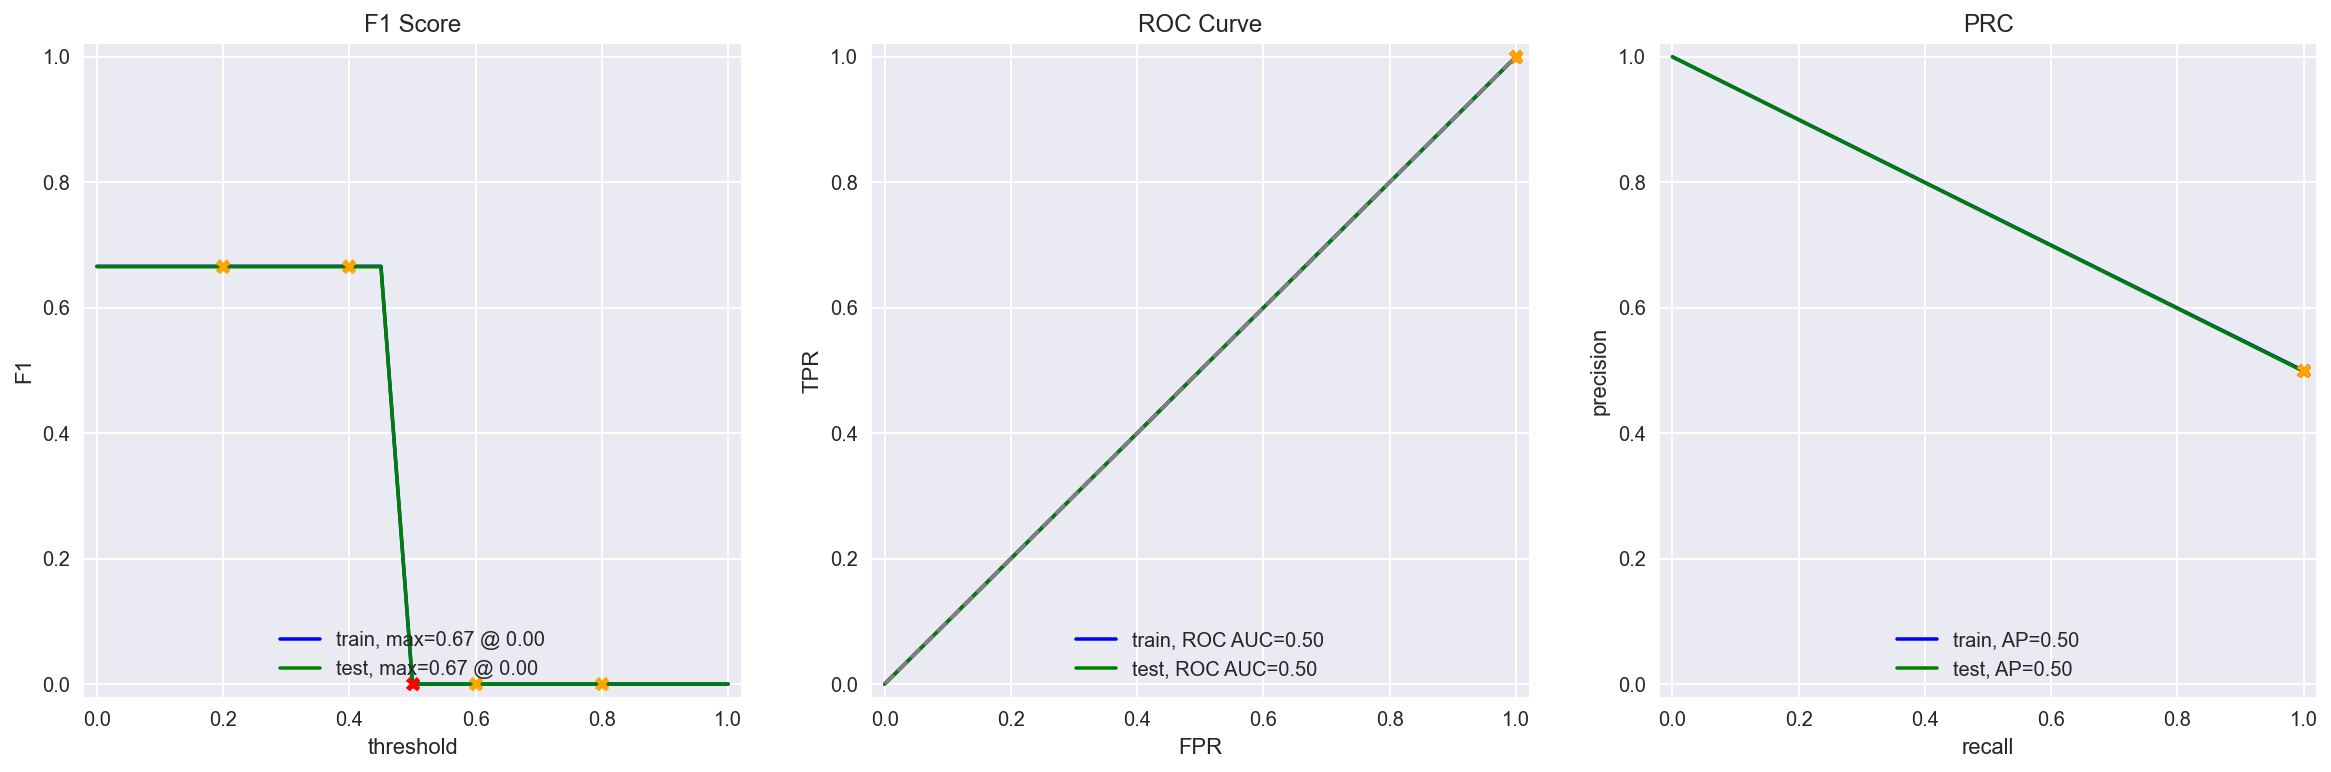

In [29]:
evaluate_model(model,X_train, y_train, X_test, y_test)

Model 0 is a coin flip. It doesn't really try to use the text to predict it just marks them all as 1 or all as zero. Since the target is balanced at almost a perfect 50-50 split than if you guess either way you will be right about 50% of the time. F1 score is zero so not a good model to use.





### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [30]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [31]:
X_train.head()

,idx,primary_title,ds_part,runtime_minutes,end_year,tconst,start_year,is_adult,rating,title_type,genres,sp,review,average_rating,votes,original_title
0,8335,$,train,121,\N,tt0068152,1971,0,1,movie,"Comedy,Crime,Drama",neg,the pakage implies that warren beatty and gold...,6.3,2218,$
1,8336,$,train,121,\N,tt0068152,1971,0,1,movie,"Comedy,Crime,Drama",neg,how the hell did they get this made presenting...,6.3,2218,$
7,9903,'Gung Ho!': The Story of Carlson's Makin Islan...,train,88,\N,tt0035958,1943,0,2,movie,"Drama,History,War",neg,this true story of carlsons raiders is more of...,6.1,1240,'Gung Ho!': The Story of Carlson's Makin Islan...
8,9905,'Gung Ho!': The Story of Carlson's Makin Islan...,train,88,\N,tt0035958,1943,0,2,movie,"Drama,History,War",neg,should have been titled balderdash little in t...,6.1,1240,'Gung Ho!': The Story of Carlson's Makin Islan...
9,9904,'Gung Ho!': The Story of Carlson's Makin Islan...,train,88,\N,tt0035958,1943,0,4,movie,"Drama,History,War",neg,the movie gung ho the story of carlsons makin ...,6.1,1240,'Gung Ho!': The Story of Carlson's Makin Islan...


In [32]:
X_train['review']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
7        this true story of carlsons raiders is more of...
8        should have been titled balderdash little in t...
9        the movie gung ho the story of carlsons makin ...
                               ...                        
47253    o my gosh just give me a minute to breath this...
47254    i cant tell you all how much i love this movie...
47255    legend of zu is possibly the most exciting mov...
47256    this movie is well done on so many levels that...
47257    as a history nut who is particularly intereste...
Name: review, Length: 23796, dtype: object

In [33]:
X_train['review'].isna().sum()

0

In [34]:

stop_words = set(stopwords.words('english'))

tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)


X_train_m1 = tfidf_vectorizer_1.fit_transform(X_train['review']) #Vectorize the text in the reviews


In [35]:
# Train the logistic regression model
clf = LogisticRegression()
clf.fit(X_train_m1, y_train)

LogisticRegression()

In [36]:
X_test_m1 = tfidf_vectorizer_1.transform(X_test['review'])

In [37]:
# Predict the test data
y_test_pred = clf.predict(X_test_m1)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


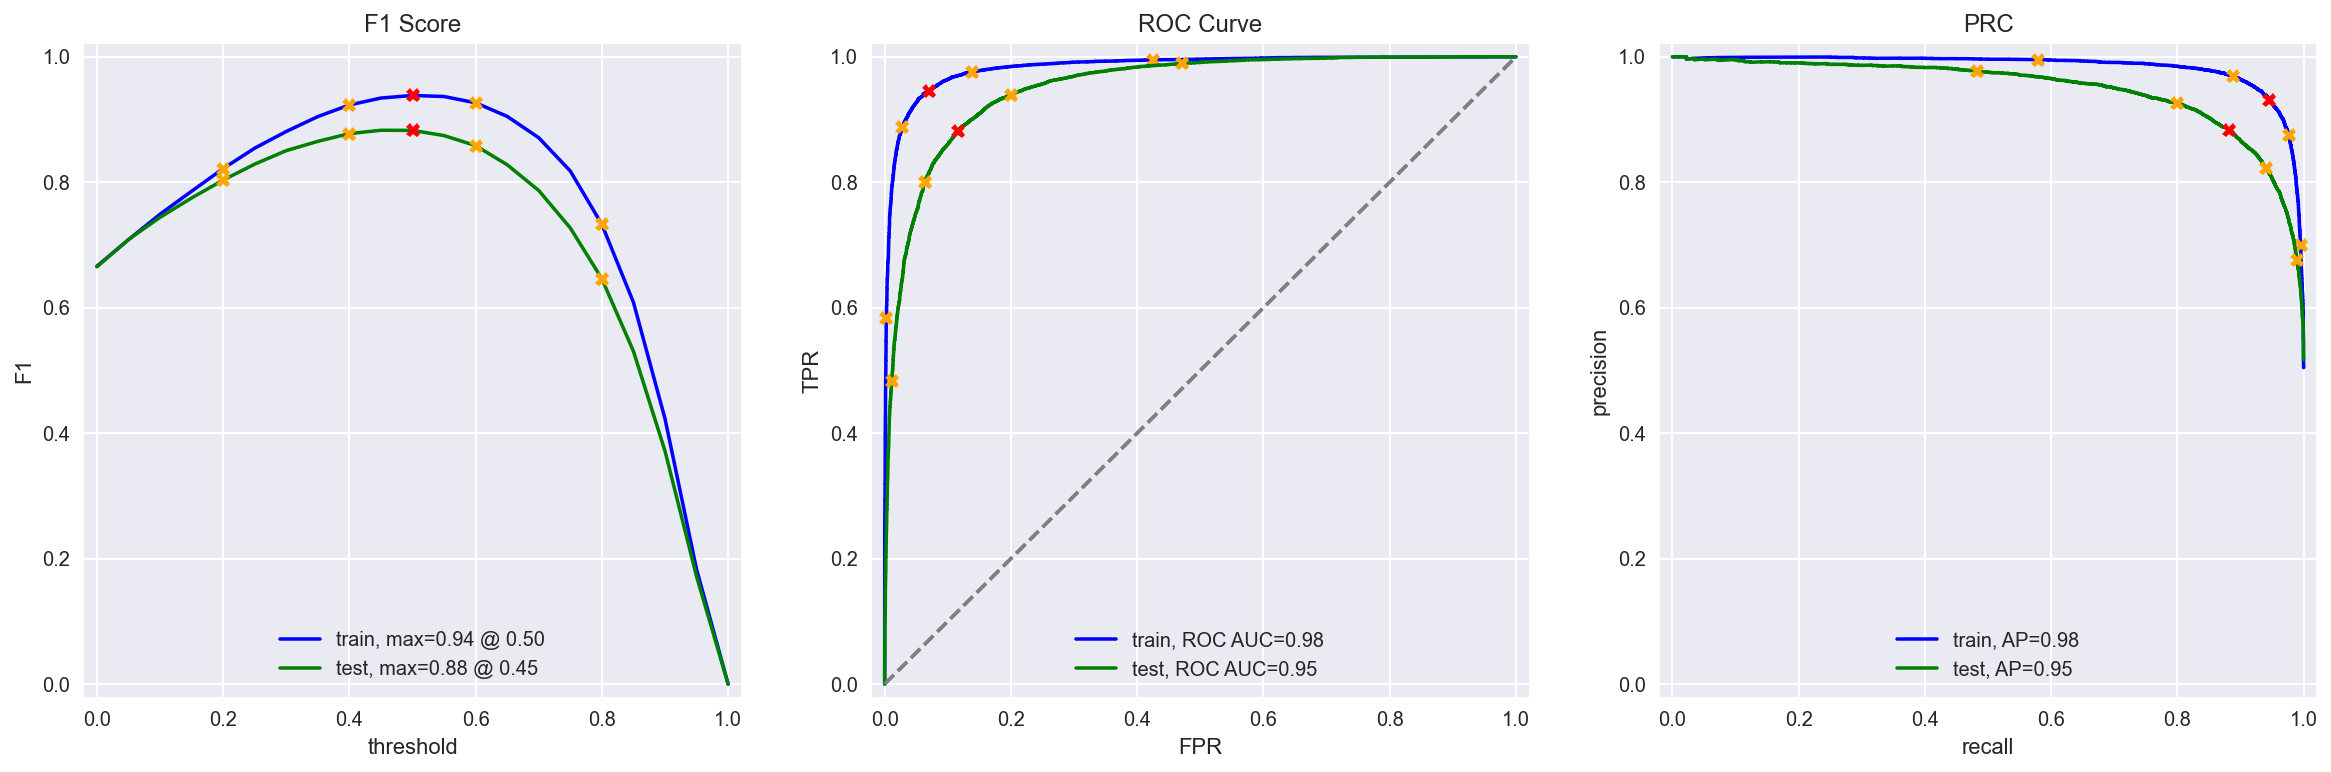

In [38]:
evaluate_model(clf, X_train_m1, y_train, X_test_m1, y_test)

### Model 2 - spaCy, TF-IDF and LGBMClassifier

In [39]:
from lightgbm import LGBMClassifier

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [41]:
# initialize TfidfVectorizer
tfidf_lgbm = TfidfVectorizer(stop_words = "english")

In [42]:
# transform the text data
X_train_tfidf = tfidf_lgbm.fit_transform(X_train['review'])
X_test_tfidf = tfidf_lgbm.transform(X_test['review'])

***LGBM Model 3***

In [52]:
model_lgbm = LGBMClassifier(num_leaves = 120,learning_rate= 0.1,n_estimators= 100).fit(X_train_tfidf, y_train)


In [53]:
y_pred_lgbm = model_lgbm.predict(X_test_tfidf)
print('F1 Score: ' + str((f1_score(y_test, y_pred_lgbm)*100).round(2))+'%')

F1 Score: 86.31%


          train  test
Accuracy   0.99  0.86
F1         0.99  0.86
APS        1.00  0.94
ROC AUC    1.00  0.94


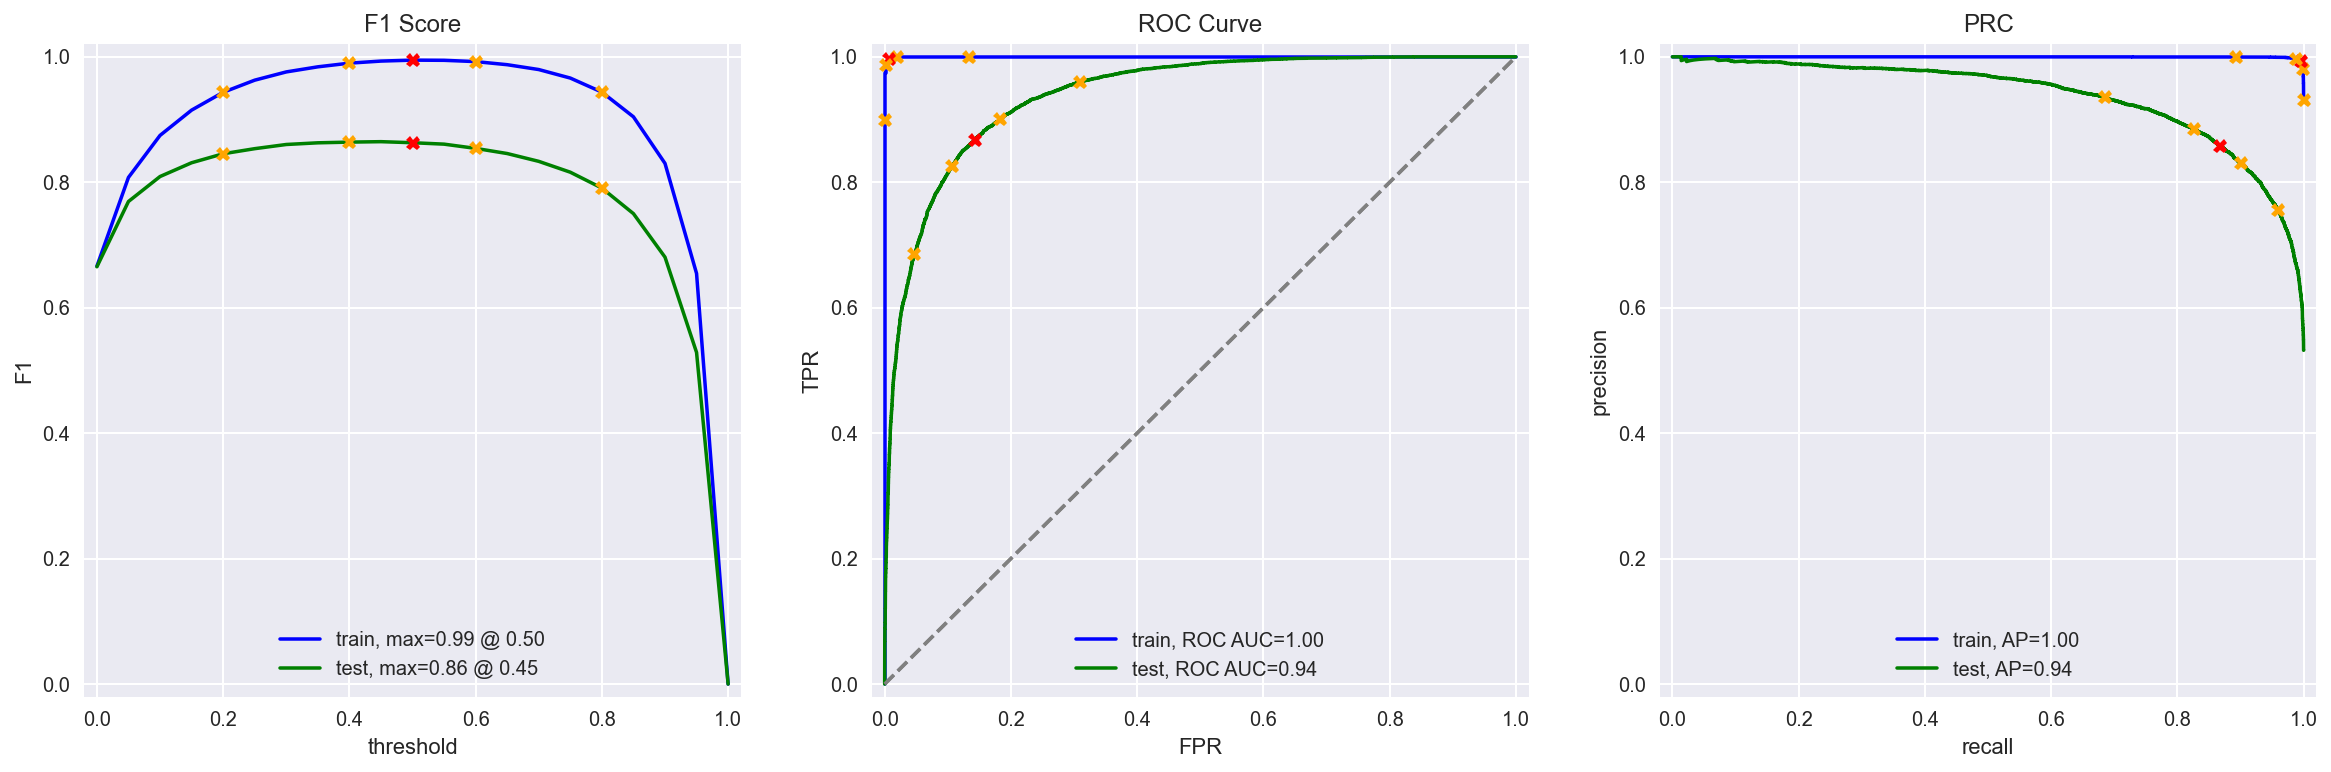

In [54]:
evaluate_model(model_lgbm, X_train_tfidf, y_train, X_test_tfidf, y_test)

### Model 3 Random Forest

          train  test
Accuracy   0.93  0.81
F1         0.94  0.81
APS        0.99  0.89
ROC AUC    0.98  0.89


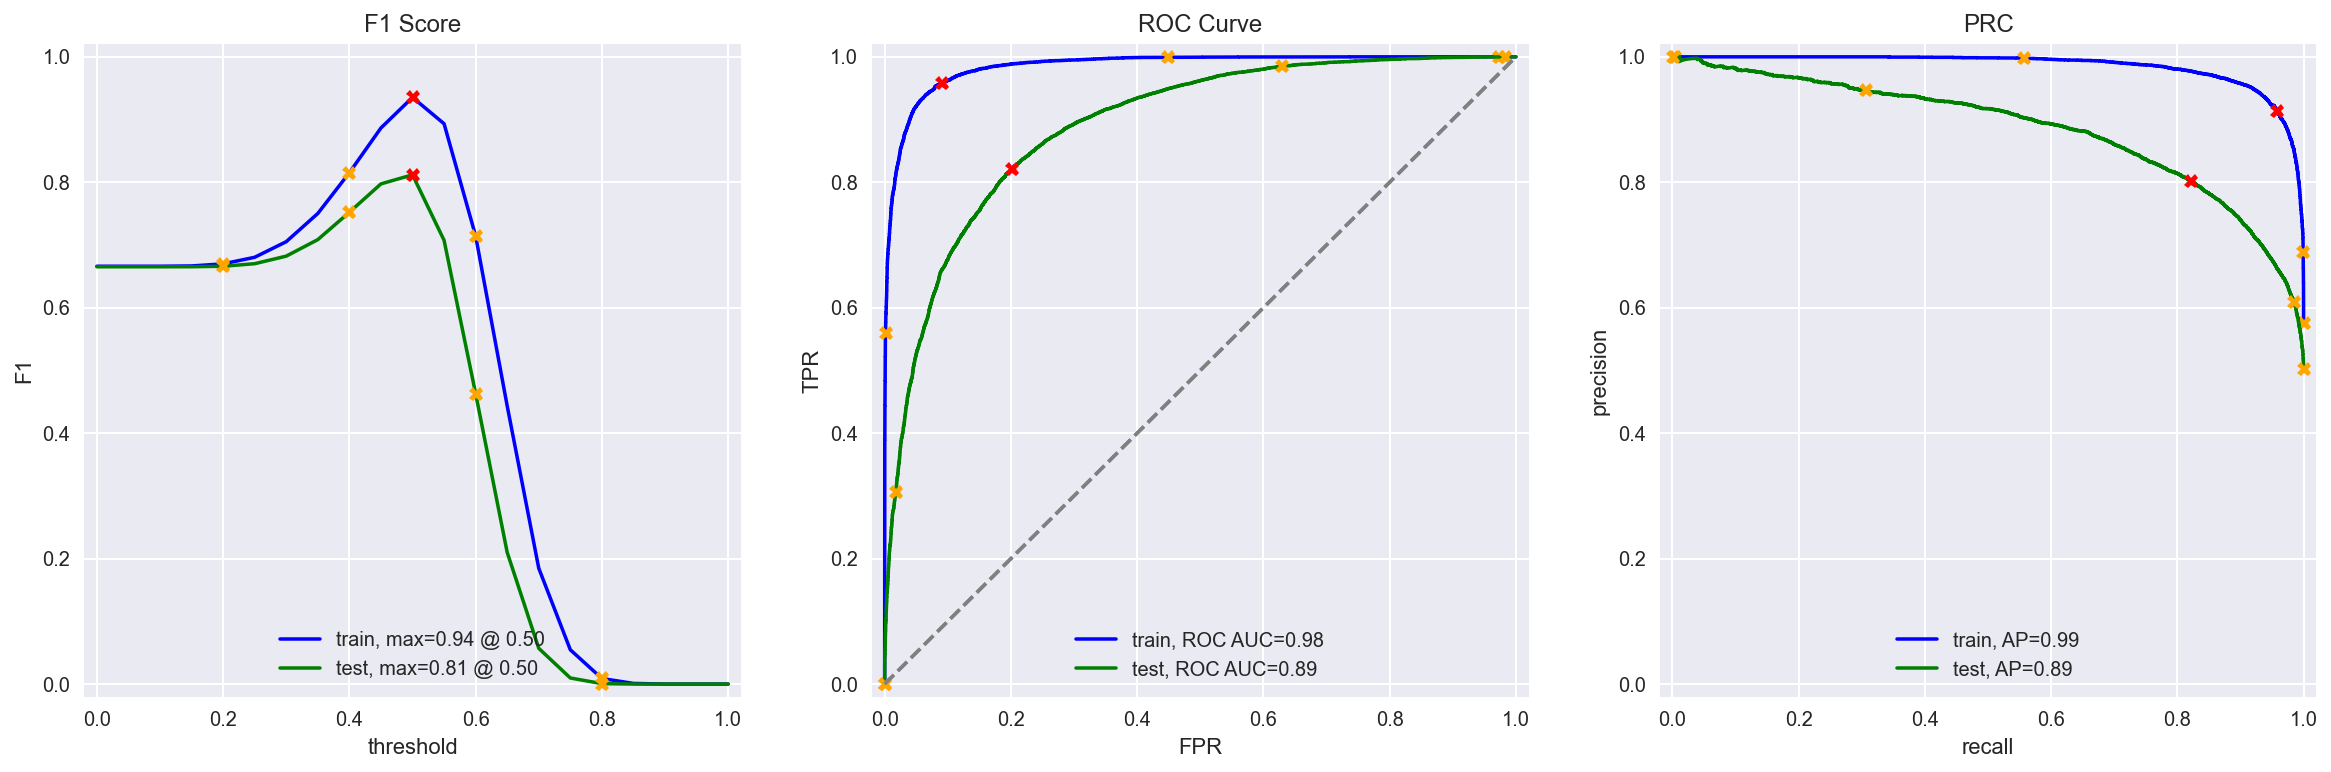

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=30, max_depth=30).fit(X_train_tfidf, y_train)
evaluate_model(rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test)

## My Reviews

In [47]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'This movie was aweful and extremely boring. I would never recommend it to anyone. Do not watch this movie. ',
    'This movie was the best movie I have ever seen in my life. Everything about it is perfect. I highly recommend it.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: x.lower()) # convert text to lowercase
my_reviews['review_norm']  = my_reviews['review_norm'].str.replace('[^\w\s]','') # remove punctuation
my_reviews['review_norm'] = my_reviews['review_norm'].str.replace('\d+', '') # remove numbers
my_reviews['review_norm'] = my_reviews['review_norm'].str.strip() # remove white spaces
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')])) # remove stop words


my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie
2,I was really fascinated with the movie,really fascinated movie
3,Even the actors looked really old and disinter...,even actors looked really old disinterested go...
4,I didn't expect the reboot to be so good! Writ...,didnt expect reboot good writers really cared ...
5,"The movie had its upsides and downsides, but I...",movie upsides downsides feel like overall dece...
6,What a rotten attempt at a comedy. Not a singl...,rotten attempt comedy single joke lands everyo...
7,Launching on Netflix was a brave move & I real...,launching netflix brave move really appreciate...
8,This movie was aweful and extremely boring. I ...,movie aweful extremely boring would never reco...
9,This movie was the best movie I have ever seen...,movie best movie ever seen life everything per...


### Model 1 - Logistic Regression

In [48]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = clf.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  simply like kind movie
0.18:  well bored felt asleep middle movie
0.56:  really fascinated movie
0.13:  even actors looked really old disinterested got paid movie soulless cash grab
0.26:  didnt expect reboot good writers really cared source material
0.48:  movie upsides downsides feel like overall decent flick could see going see
0.05:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wont like
0.84:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d
0.17:  movie aweful extremely boring would never recommend anyone watch movie
1.00:  movie best movie ever seen life everything perfect highly recommend


### Model 2 - Light GBM

In [49]:
texts = my_reviews['review_norm']


my_reviews_pred_prob = model_lgbm.predict_proba(tfidf_lgbm.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:  simply like kind movie
0.11:  well bored felt asleep middle movie
0.66:  really fascinated movie
0.33:  even actors looked really old disinterested got paid movie soulless cash grab
0.29:  didnt expect reboot good writers really cared source material
0.62:  movie upsides downsides feel like overall decent flick could see going see
0.12:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wont like
0.89:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d
0.19:  movie aweful extremely boring would never recommend anyone watch movie
0.99:  movie best movie ever seen life everything perfect highly recommend


### Model 3 - Random Forest

In [50]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = rf_model.predict_proba(tfidf_lgbm.transform(texts))[:, 1]


In [51]:

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.53:  simply like kind movie
0.51:  well bored felt asleep middle movie
0.53:  really fascinated movie
0.50:  even actors looked really old disinterested got paid movie soulless cash grab
0.50:  didnt expect reboot good writers really cared source material
0.52:  movie upsides downsides feel like overall decent flick could see going see
0.48:  rotten attempt comedy single joke lands everyone acts annoying loud even kids wont like
0.56:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d
0.56:  movie aweful extremely boring would never recommend anyone watch movie
0.62:  movie best movie ever seen life everything perfect highly recommend


<div class="alert alert-success">
<b>Reviewer's comment</b>

The models were applied to custom reviews correctly
    

</div>

## Conclusions

I just want to begin by saying I used the data I was given was only split into test and train so I did not have a validation set to cross validate and find parameters on. 

I tested models for Logistic Regression, Light GBM and a Random Forest. Out of these 3 we found that the Logistic Regression Model did the best with an F1 score of 88% for the test set, Light GBM came next with a score of 86%. Both are above the minimal F1 score required of 85%.

For our customer, Film Junky Union, we would offer the LR model for it's high F1 score of 88% which means it can predict negative reviews with a high degree of accuracy. 

We can see that as far as our own reviews Random Forest is bunched in the 50's of probability which could very narrowly be classified as positive or negative. We want those predictions probabilities to be as close to zero for reviews we read and are clearly negative and as close to one for those that are extremely positive. Logistic regression for example gave my last stellar review a probability of a perfect one or very close to it.

I believe the Logistic Regression model did best because it is a binary classification so it is just a zero or one . But if the classification was a lot more complex and we had to classify the text say into 20 categories then I believe Light GBM would do better since it can figure out non linear solutions to the classification problem. 

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions